In [24]:
import quimb.tensor as qtn

In [25]:
Lx = 4
Ly = 4

In [26]:
peps = qtn.PEPS.rand(Lx, Ly, 2, seed=42)

In [27]:
def delocalize_in_cross(peps, diag=False):

    peps = peps.copy()

    for (i, j) in peps.sites:
        t = peps[i, j]

        if diag:
            neighbors = [
                (i + 1, j + 1),
                (i - 1, j - 1),
                (i + 1, j - 1),
                (i - 1, j + 1),
            ]
        else:
            neighbors = [
                (i + 1, j),
                (i - 1, j),
                (i, j + 1),
                (i, j - 1),
            ]
        for neighbor in neighbors:
            if peps.valid_coo(neighbor):
                t.new_ind(peps.site_ind(neighbor), mode="repeat", size=2)
    return peps

In [28]:
dpeps = delocalize_in_cross(peps, diag=False)

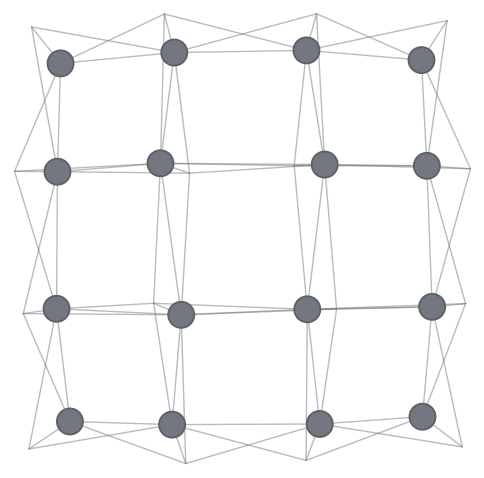

In [29]:
dpeps.draw()

In [30]:
from vmc_torch.experiment.tn_model import PEPS_model, PEPS_delocalized_Model

In [35]:
import torch
peps.apply_to_arrays(torch.tensor)
dpeps.apply_to_arrays(torch.tensor)
peps_model = PEPS_model(peps)
dpeps_model = PEPS_delocalized_Model(peps, diag=False)

/home/sijingdu/TNVMC/VMC_code/quimb/quimb/utils.py:571: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return f(tree)


In [36]:
len(peps_model.from_params_to_vec()), len(dpeps_model.from_params_to_vec())

(288, 3200)

In [39]:
peps1 = qtn.PEPS.rand(Lx, Ly, 4, seed=42)
peps1.apply_to_arrays(torch.tensor)
peps1_model = PEPS_model(peps1)
len(peps1_model.from_params_to_vec())

3200

In [37]:
test_mlp = torch.nn.Sequential(
    torch.nn.Linear(16, 288),
)
# number of parameters in the test_mlp
sum(p.numel() for p in test_mlp.parameters())

4896